# QUASI-RECURRENT NEURAL NETWORKS
- https://arxiv.org/abs/1611.01576

## 1. Introduction

### RNN
<img src="https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/IgT/image/0KQEHorp3Mpiwo5H9zQpeMQv4SE.png">

- __RNN(LSTM)__ have become the standard model architecture for deep learning __approaches to sequence modeling tasks.__
- RNN(LSTM)설명 : https://brunch.co.kr/@chris-song/9
- RNNs repeatedly apply a function with trainable parameters to a hidden state. 
- RNN applications in the natural language domain range from sentence classification to word- and character-level language modeling. 
- RNNs are also commonly the basic building block for more complex models for tasks such as machine translation or question answering. 
- Unfortunately standard RNNs, including LSTMs, are limited in their capability to handle tasks involving very long sequences, such as document classification or character-level machine translation, as the computation of features or states for different parts of the document cannot occur in parallel.

### CNN
<img src="http://i.stack.imgur.com/HyAs5.png">
- more popular on tasks involving image data, have also been applied to sequence encoding tasks.
- Such models apply time-invariant filter functions in parallel to windows along the input sequence. 
- CNNs possess several advantages over recurrent models, including increased parallelism and better scaling to long sequences such as those often seen with character-level language data. 
- Convolutional models for sequence processing have been more successful when combined with RNN layers in a hybrid architecture (Lee et al., 2016), because traditional max- and average-pooling approaches to combining convolutional features across timesteps assume time invariance and hence cannot make full use of large-scale sequence order information.

- We present quasi-recurrent neural networks for neural sequence modeling. 
- QRNNs address both drawbacks of standard models: 
    - __Like CNNs,__ QRNNs allow for parallel computation across both timestep and minibatch dimensions, enabling high throughput and good scaling to long sequences. 
    - __Like RNNs,__ QRNNs allow the output to depend on the overall order of elements in the sequence. 
- We describe QRNN variants tailored to several natural language tasks, including document-level sentiment classification, language modeling, and character-level machine translation. These models outperform strong LSTM baselines on all three tasks while dramatically reducing computation time.

<img src="http://metamind.io/images/qrnn_block.svg">

## 2. Model
- https://theneuralperspective.com/2016/12/16/quasi-recurrent-neural-networks/

# 실습

In [13]:
import os
import time
import functools
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from matplotlib import pylab
%matplotlib inline

In [14]:
digits = load_digits()
digits

{'DESCR': "Optical Recognition of Handwritten Digits Data Set\n===================================================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixels ar

In [15]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [16]:
digits.images.shape

(1797, 8, 8)

In [17]:
digits.images[3]

array([[  0.,   0.,   7.,  15.,  13.,   1.,   0.,   0.],
       [  0.,   8.,  13.,   6.,  15.,   4.,   0.,   0.],
       [  0.,   2.,   1.,  13.,  13.,   0.,   0.,   0.],
       [  0.,   0.,   2.,  15.,  11.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.,  12.,  12.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   1.,  10.,   8.,   0.],
       [  0.,   0.,   8.,   4.,   5.,  14.,   9.,   0.],
       [  0.,   0.,   7.,  13.,  13.,   9.,   0.,   0.]])

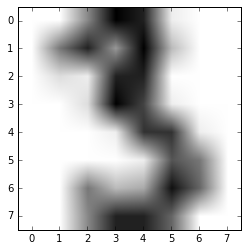

In [18]:
pylab.imshow(digits.images[3], cmap=pylab.cm.gray_r)

In [19]:
digits.target[3]

3

In [20]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
def check_by_digits(graph, qrnn=-1, baseline=False, random=False):
    digits = load_digits()
    horizon, vertical, n_class = (8, 8, 10)  # 8 x 8 image, 0~9 number(=10 class)
    size = 128  # state vector size
    batch_size = 128
    images = digits.images / np.max(digits.images)  # simple normalization
    target = np.array([[1 if t == i else 0 for i in range(n_class)] for t in digits.target])  # to 1 hot vector
    learning_rate = 0.001
    train_iter = 1000
    summary_dir = os.path.join(os.getcwd(), "./summary")

    with tf.name_scope("placeholder"):
        X = tf.placeholder(tf.float32, [batch_size, vertical, horizon])
        y = tf.placeholder(tf.float32, [batch_size, n_class])

    # 예측값 pred를 아래 3가지 경우에 따라서 구함.
    if qrnn > 0:
        pred = qrnn_forward(X, size, n_class, batch_size, conv_size=qrnn)
        summary_dir += "/qrnn"
    elif baseline:
        pred = baseline_forward(X, size, n_class)
        summary_dir += "/lstm"
    else:
        pred = random_forward(X, size, n_class)            
        summary_dir += "/random"

    with tf.name_scope("optimization"):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    with tf.name_scope("evaluation"):
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    with tf.name_scope("summary"):
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("accuracy", accuracy)
        merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter(summary_dir, graph)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(train_iter):
            indices = np.random.randint(len(digits.target) - batch_size, size=batch_size) # 0부터 1797-128중에서의 random int 128개   
            _X = images[indices]
            _y = target[indices]
            sess.run(optimizer, feed_dict={X: _X, y: _y})

            if i % 100 == 0:
                _loss, _accuracy, _merged = sess.run([loss, accuracy, merged], feed_dict={X: _X, y: _y})
                writer.add_summary(_merged, i)
                print("Iter {}: loss={}, accuracy={}".format(i, _loss, _accuracy))

        with tf.name_scope("test-evaluation"):
            acc = sess.run(accuracy, feed_dict={X: images[-batch_size:], y: target[-batch_size:]})
            print("Testset Accuracy={}".format(acc))

### Random forward

In [22]:
def random_forward(X, size, n_class):
    batch_size = int(X.get_shape()[0])

    with tf.name_scope("Random-Classifier"):
        rand_vector = tf.random_normal([batch_size, size])  # batch_size x size random vector
        W = tf.Variable(tf.random_normal([size, n_class]), name="W")
        b = tf.Variable(tf.random_normal([n_class]), name="b")
        output = tf.matmul(rand_vector, W) + b
    return output

### Baseline forward

In [23]:
def baseline_forward(X, size, n_class):
    shape = X.get_shape()
    _X = tf.transpose(X, [1, 0, 2])  # batch_size x sentence_length x word_length -> batch_size x sentence_length x word_length
    _X = tf.reshape(_X, [-1, int(shape[2])])  # (batch_size x sentence_length) x word_length
    seq = tf.split(0, int(shape[1]), _X)  # sentence_length x (batch_size x word_length)

    with tf.name_scope("LSTM"):
        lstm_cell = rnn_cell.BasicLSTMCell(size, forget_bias=1.0)
        outputs, states = rnn.rnn(lstm_cell, seq, dtype=tf.float32)

    with tf.name_scope("LSTM-Classifier"):
        W = tf.Variable(tf.random_normal([size, n_class]), name="W")
        b = tf.Variable(tf.random_normal([n_class]), name="b")
        output = tf.matmul(outputs[-1], W) + b

    return output

### QRNN forward

In [24]:
def qrnn_forward(X, size, n_class, batch_size, conv_size):
    in_size = int(X.get_shape()[2])

    qrnn = QRNN(in_size=in_size, size=size, conv_size=conv_size)
    hidden = qrnn.forward(X)

    with tf.name_scope("QRNN-Classifier"):
        W = tf.Variable(tf.random_normal([size, n_class]), name="W")
        b = tf.Variable(tf.random_normal([n_class]), name="b")
        output = tf.add(tf.matmul(hidden, W), b)
    return output

In [25]:
def test_random():
    print("Random Working check")
    with tf.Graph().as_default() as random:
        check_by_digits(random, random=True)

In [26]:
%%time
test_random()

Random Working check
Iter 0: loss=17.487810134887695, accuracy=0.09375
Iter 100: loss=19.236494064331055, accuracy=0.1015625
Iter 200: loss=16.416854858398438, accuracy=0.078125
Iter 300: loss=15.105697631835938, accuracy=0.078125
Iter 400: loss=15.88584041595459, accuracy=0.1015625
Iter 500: loss=14.164024353027344, accuracy=0.09375
Iter 600: loss=15.28477668762207, accuracy=0.0703125
Iter 700: loss=13.537178039550781, accuracy=0.125
Iter 800: loss=12.486244201660156, accuracy=0.1484375
Iter 900: loss=11.974689483642578, accuracy=0.078125
Testset Accuracy=0.109375
CPU times: user 2.03 s, sys: 205 ms, total: 2.24 s
Wall time: 1.67 s


In [27]:
def test_baseline():
    print("Baseline(LSTM) Working check")
    with tf.Graph().as_default() as baseline:
        check_by_digits(baseline, baseline=True)

In [28]:
%%time
test_baseline()

Baseline(LSTM) Working check
Iter 0: loss=2.405916452407837, accuracy=0.1328125
Iter 100: loss=0.35039275884628296, accuracy=0.9140625
Iter 200: loss=0.2035084068775177, accuracy=0.9296875
Iter 300: loss=0.05401304364204407, accuracy=0.9765625
Iter 400: loss=0.021765559911727905, accuracy=1.0
Iter 500: loss=0.015437640249729156, accuracy=1.0
Iter 600: loss=0.028048399835824966, accuracy=1.0
Iter 700: loss=0.02051163837313652, accuracy=1.0
Iter 800: loss=0.004900586325675249, accuracy=1.0
Iter 900: loss=0.009282441809773445, accuracy=1.0
Testset Accuracy=0.9453125
CPU times: user 56.7 s, sys: 3 s, total: 59.7 s
Wall time: 25 s


In [34]:
class QRNN():
    def __init__(self, in_size, size, conv_size=2):
        self.kernel = None
        self.batch_size = -1
        self.conv_size = conv_size
        self.c = None
        self.h = None
        self._x = None
        if conv_size == 1:
            self.kernel = QRNNLinear(in_size, size)
        elif conv_size == 2:
            self.kernel = QRNNWithPrevious(in_size, size)
        else:
            self.kernel = QRNNConvolution(in_size, size, conv_size)

    def _step(self, f, z, o):
        with tf.variable_scope("fo-Pool"):
            # f,z,o is batch_size x size
            f = tf.sigmoid(f)
            z = tf.tanh(z)
            o = tf.sigmoid(o)
            self.c = tf.mul(f, self.c) + tf.mul(1 - f, z)
            self.h = tf.mul(o, self.c)  # h is size vector

        return self.h

    def forward(self, x):
        length = lambda mx: int(mx.get_shape()[0])

        with tf.variable_scope("QRNN/Forward"):
            if self.c is None:
                # init context cell
                self.c = tf.zeros([length(x), self.kernel.size], dtype=tf.float32)

            if self.conv_size <= 2:
                # x is batch_size x sentence_length x word_length
                # -> now, transpose it to sentence_length x batch_size x word_length
                _x = tf.transpose(x, [1, 0, 2])

                for i in range(length(_x)):
                    t = _x[i] # t is batch_size x word_length matrix
                    f, z, o = self.kernel.forward(t)
                    self._step(f, z, o)
            else:
                c_f, c_z, c_o = self.kernel.conv(x)
                for i in range(length(c_f)):
                    f, z, o = c_f[i], c_z[i], c_o[i]
                    self._step(f, z, o)

        return self.h

In [32]:
class QRNNLinear():
    def __init__(self, in_size, size):
        self.in_size = in_size
        self.size = size
        self._weight_size = self.size * 3  # z, f, o
        with tf.variable_scope("QRNN/Variable/Linear"):
            initializer = tf.random_normal_initializer()
            self.W = tf.get_variable("W", [self.in_size, self._weight_size], initializer=initializer)
            self.b = tf.get_variable("b", [self._weight_size], initializer=initializer)

    def forward(self, t):
        # x is batch_size x word_length matrix
        _weighted = tf.matmul(t, self.W)
        _weighted = tf.add(_weighted, self.b)

        # now, _weighted is batch_size x weight_size
        f, z, o = tf.split(1, 3, _weighted)  # split to f, z, o. each matrix is batch_size x size
        return f, z, o

In [33]:
class QRNNWithPrevious():

    def __init__(self, in_size, size):
        self.in_size = in_size
        self.size = size
        self._weight_size = self.size * 3  # z, f, o
        self._previous = None
        with tf.variable_scope("QRNN/Variable/WithPrevious"):
            initializer = tf.random_normal_initializer()
            self.W = tf.get_variable("W", [self.in_size, self._weight_size], initializer=initializer)
            self.V = tf.get_variable("V", [self.in_size, self._weight_size], initializer=initializer)
            self.b = tf.get_variable("b", [self._weight_size], initializer=initializer)

    def forward(self, t):
        if self._previous is None:
            self._previous = tf.get_variable("previous", [t.get_shape()[0], self.in_size], initializer=tf.random_normal_initializer())

        _current = tf.matmul(t, self.W)
        _previous = tf.matmul(self._previous, self.V)
        _previous = tf.add(_previous, self.b)
        _weighted = tf.add(_current, _previous)

        f, z, o = tf.split(1, 3, _weighted)  # split to f, z, o. each matrix is batch_size x size
        self._previous = t
        return f, z, o


In [30]:
class QRNNConvolution():

    def __init__(self, in_size, size, conv_size):
        self.in_size = in_size
        self.size = size
        self.conv_size = conv_size
        self._weight_size = self.size * 3  # z, f, o

        with tf.variable_scope("QRNN/Variable/Convolution"):
            initializer = tf.random_normal_initializer()
            self.conv_filter = tf.get_variable("conv_filter", [conv_size, in_size, self._weight_size], initializer=initializer)

    def conv(self, x):
        # !! x is batch_size x sentence_length x word_length(=channel) !!
        _weighted = tf.nn.conv1d(x, self.conv_filter, stride=1, padding="SAME", data_format="NHWC")

        # _weighted is batch_size x conved_size x output_channel
        _w = tf.transpose(_weighted, [1, 0, 2])  # conved_size x  batch_size x output_channel
        _ws = tf.split(2, 3, _w) # make 3(f, z, o) conved_size x  batch_size x size
        return _ws

In [141]:
tf.nn.conv1d?

In [43]:
def test_qrnn():
    print("QRNN Working check")
    with tf.Graph().as_default() as qrnn:
        check_by_digits(qrnn, qrnn=20)

In [44]:
%%time
test_qrnn()

QRNN Working check
Iter 0: loss=7.124448299407959, accuracy=0.0390625
Iter 100: loss=1.197694182395935, accuracy=0.6640625
Iter 200: loss=0.4061892628669739, accuracy=0.8671875
Iter 300: loss=0.1676613986492157, accuracy=0.9453125
Iter 400: loss=0.10967914760112762, accuracy=0.96875
Iter 500: loss=0.08891242742538452, accuracy=0.9765625
Iter 600: loss=0.05394919961690903, accuracy=0.9765625
Iter 700: loss=0.027798496186733246, accuracy=1.0
Iter 800: loss=0.024984735995531082, accuracy=1.0
Iter 900: loss=0.009005965664982796, accuracy=1.0
Testset Accuracy=0.9296875
CPU times: user 1min 13s, sys: 6.7 s, total: 1min 20s
Wall time: 26.2 s
